In [ ]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

Firstly, we read the input (frequency change by years) abd put them in a list

In [2]:
# load Input data and normalize
dir = '../result/HumanN2_freqchg.csv'
Freq_df = pd.read_csv(dir)
resi_ls = []
resi_df_ls = []
for resi in range(469):
    df = Freq_df[Freq_df['pos'] == (resi+1)]
    df = df.loc[:,["year_vec","mut_freq"]]
    df.loc[(df.mut_freq < 0.02),"mut_freq"]=0
    #df.loc[(df.mut_freq >= 0.2),"mut_freq"]=1
    df.set_index('year_vec',inplace=True)
    # set the date columns as index
    df.sort_index(inplace=True)
    resi_df_ls.append(df)
    resi_ls.append('Residues '+str(resi+1))
print(len(resi_df_ls))

469


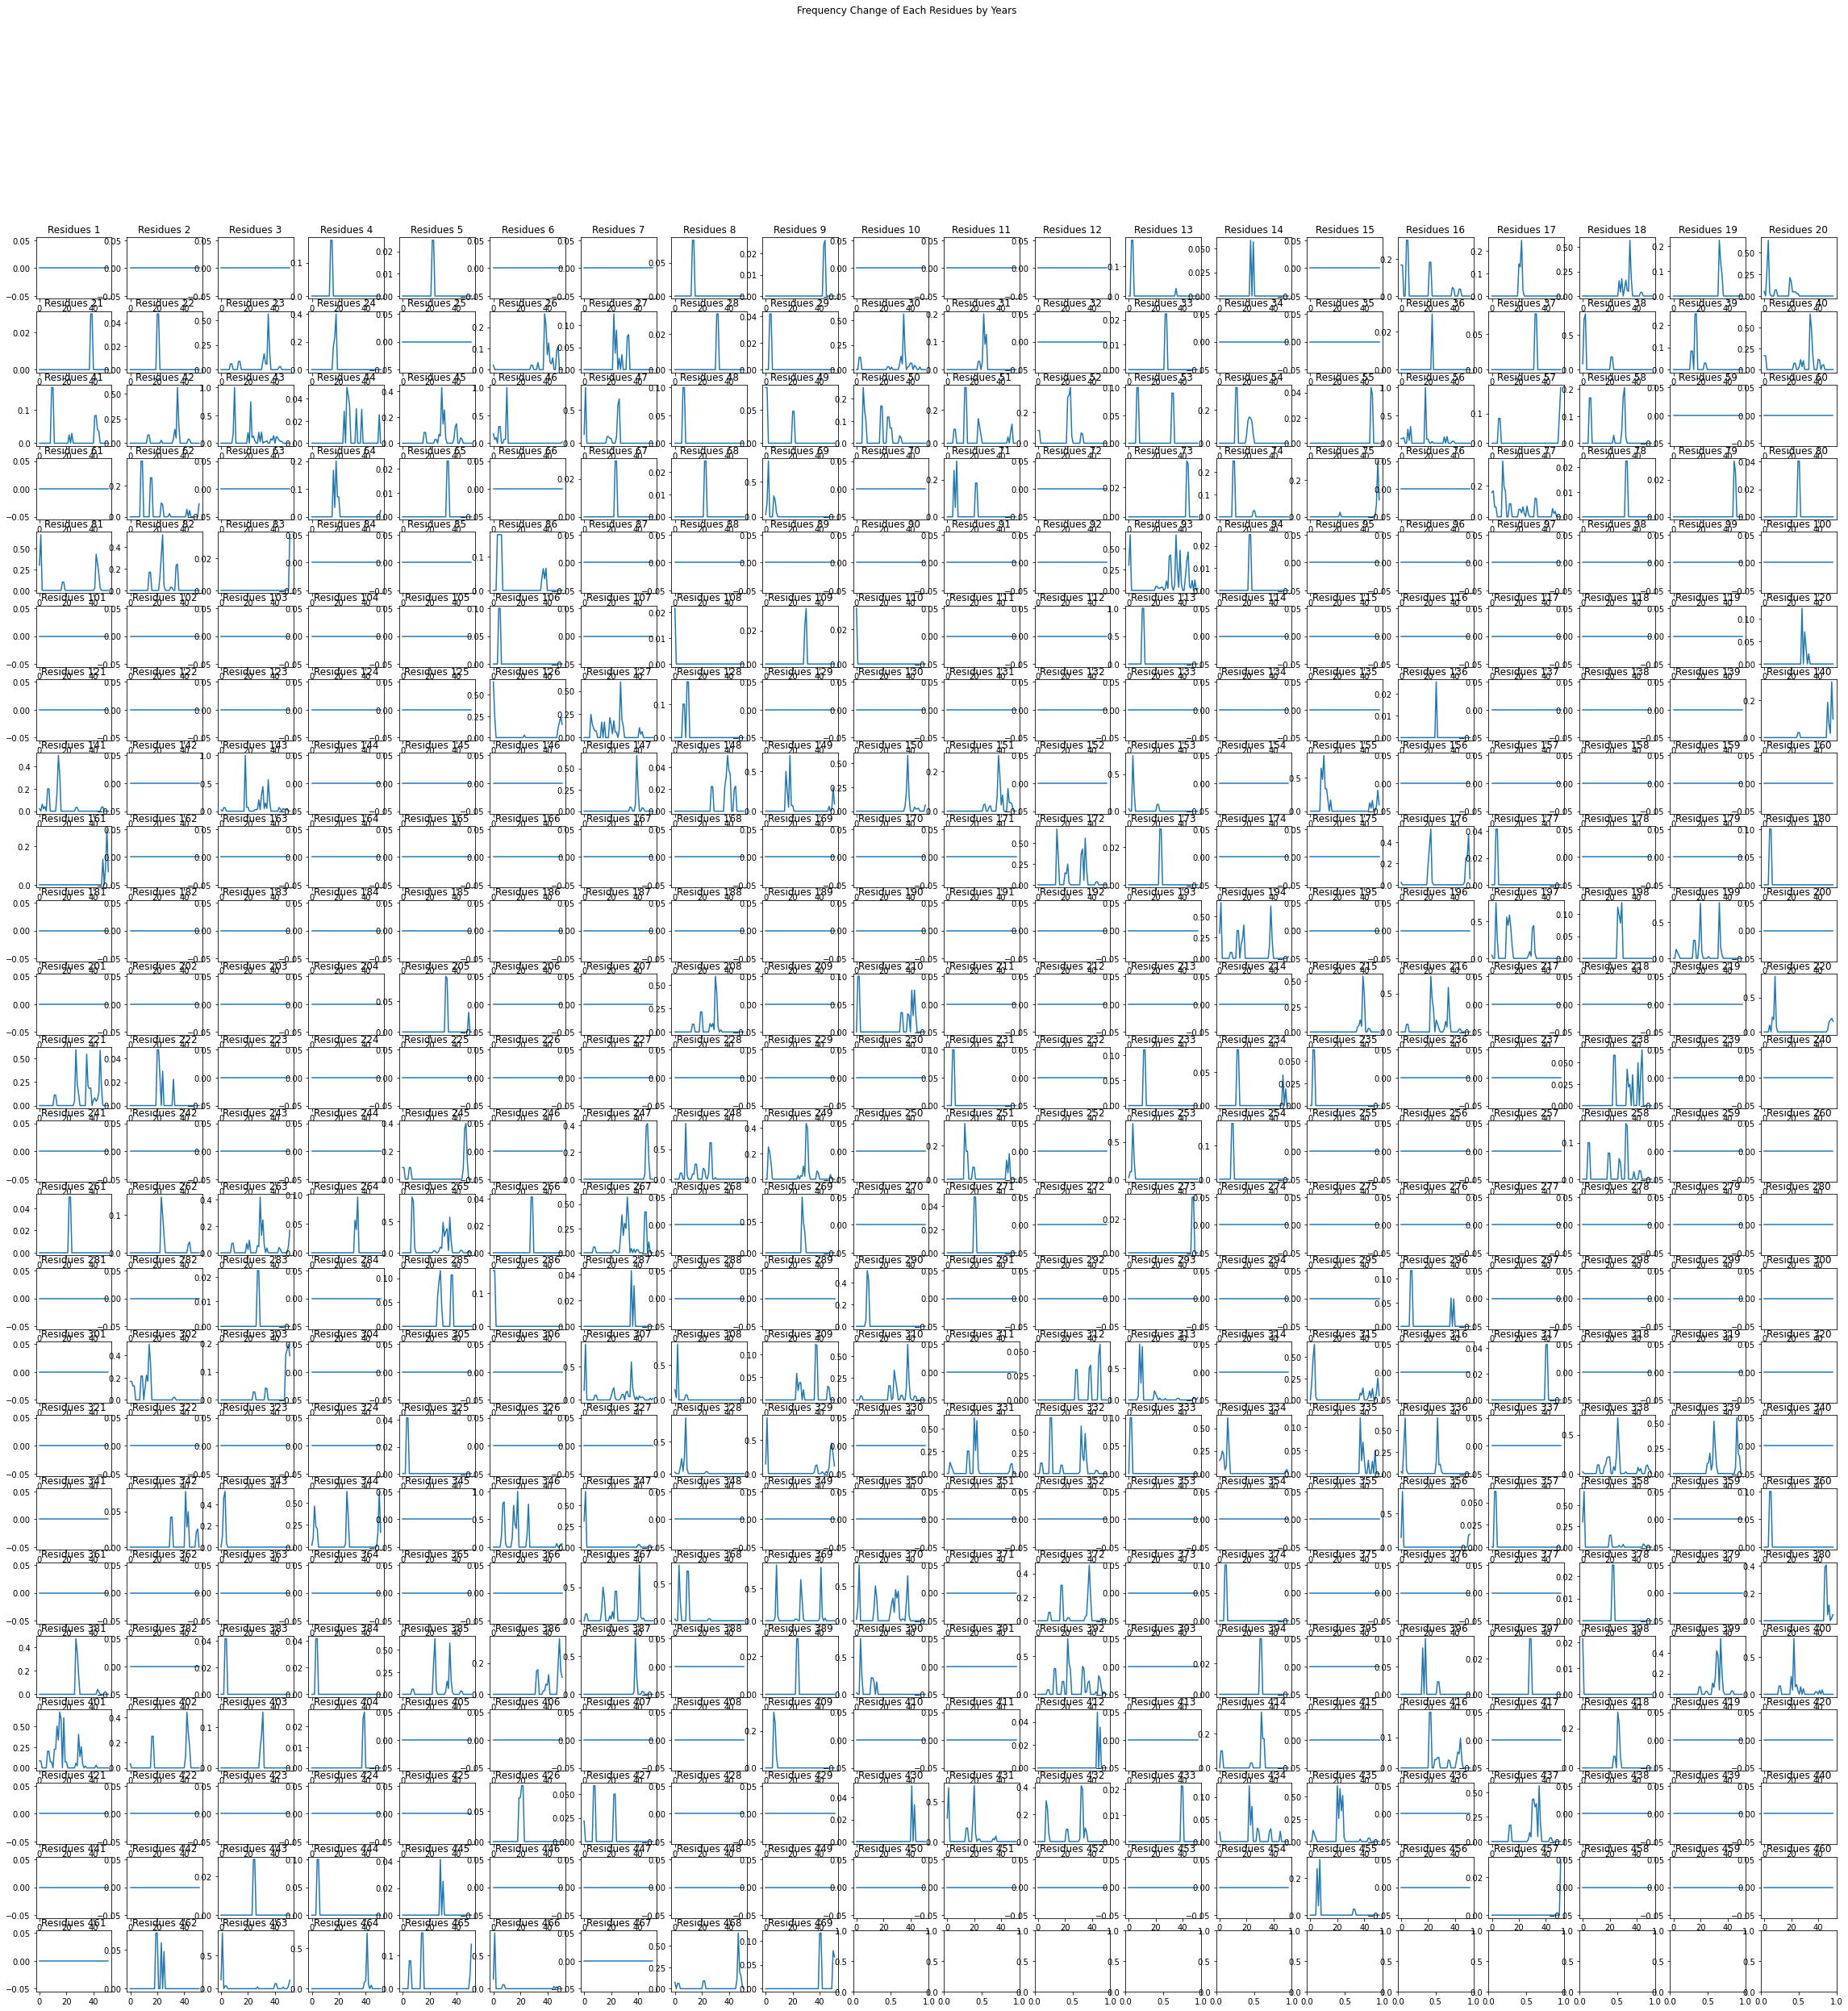

In [3]:
fig, axs = plt.subplots(24,20,figsize=(40,40))
fig.suptitle('Frequency Change of Each Residues by Years')
for i in range(24):
    for j in range(20):
        if i*20+j+1>len(resi_df_ls): # pass the others that we can't fill
            continue
        axs[i, j].plot(resi_df_ls[i*20+j].values)
        axs[i, j].set_title(resi_ls[i*20+j])
plt.show()

In [4]:
resi_df_lengths = {len(resi_df) for resi_df in resi_df_ls}
print(resi_df_lengths)

{52}


In [5]:
#normailze data
for i in range(len(resi_df_ls)):
    scaler = MinMaxScaler()
    resi_df_ls[i] = MinMaxScaler().fit_transform(resi_df_ls[i])
    resi_df_ls[i]= resi_df_ls[i].reshape(len(resi_df_ls[i]))
print("max: "+str(max(resi_df_ls[0]))+"\tmin: "+str(min(resi_df_ls[0])))
print(resi_df_ls[0][:5])

max: 0.0	min: 0.0
[0. 0. 0. 0. 0.]


In [6]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(resi_df_ls))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(resi_df_ls[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(resi_df_ls)
som.train(resi_df_ls, 50000)

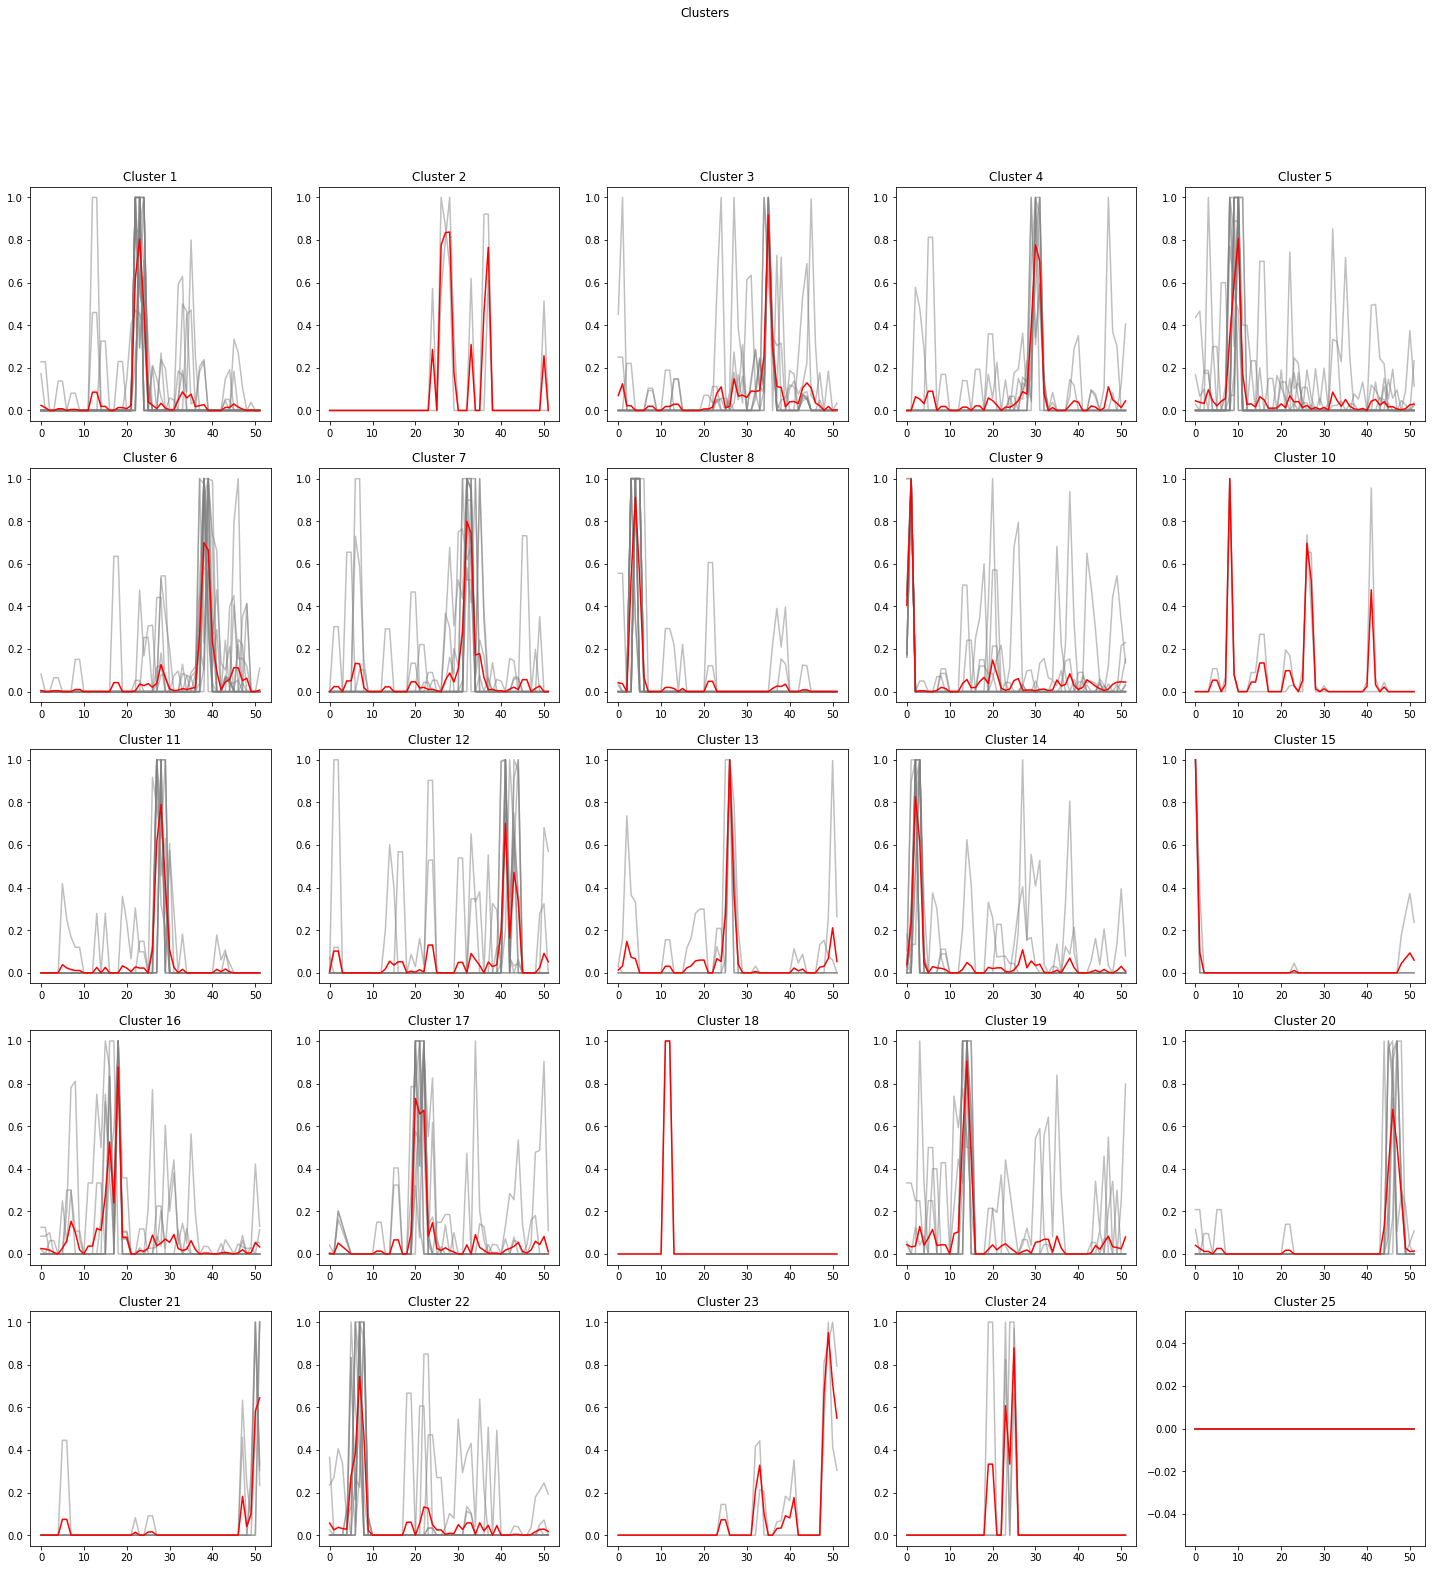

In [7]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()
win_map = som.win_map(resi_df_ls)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

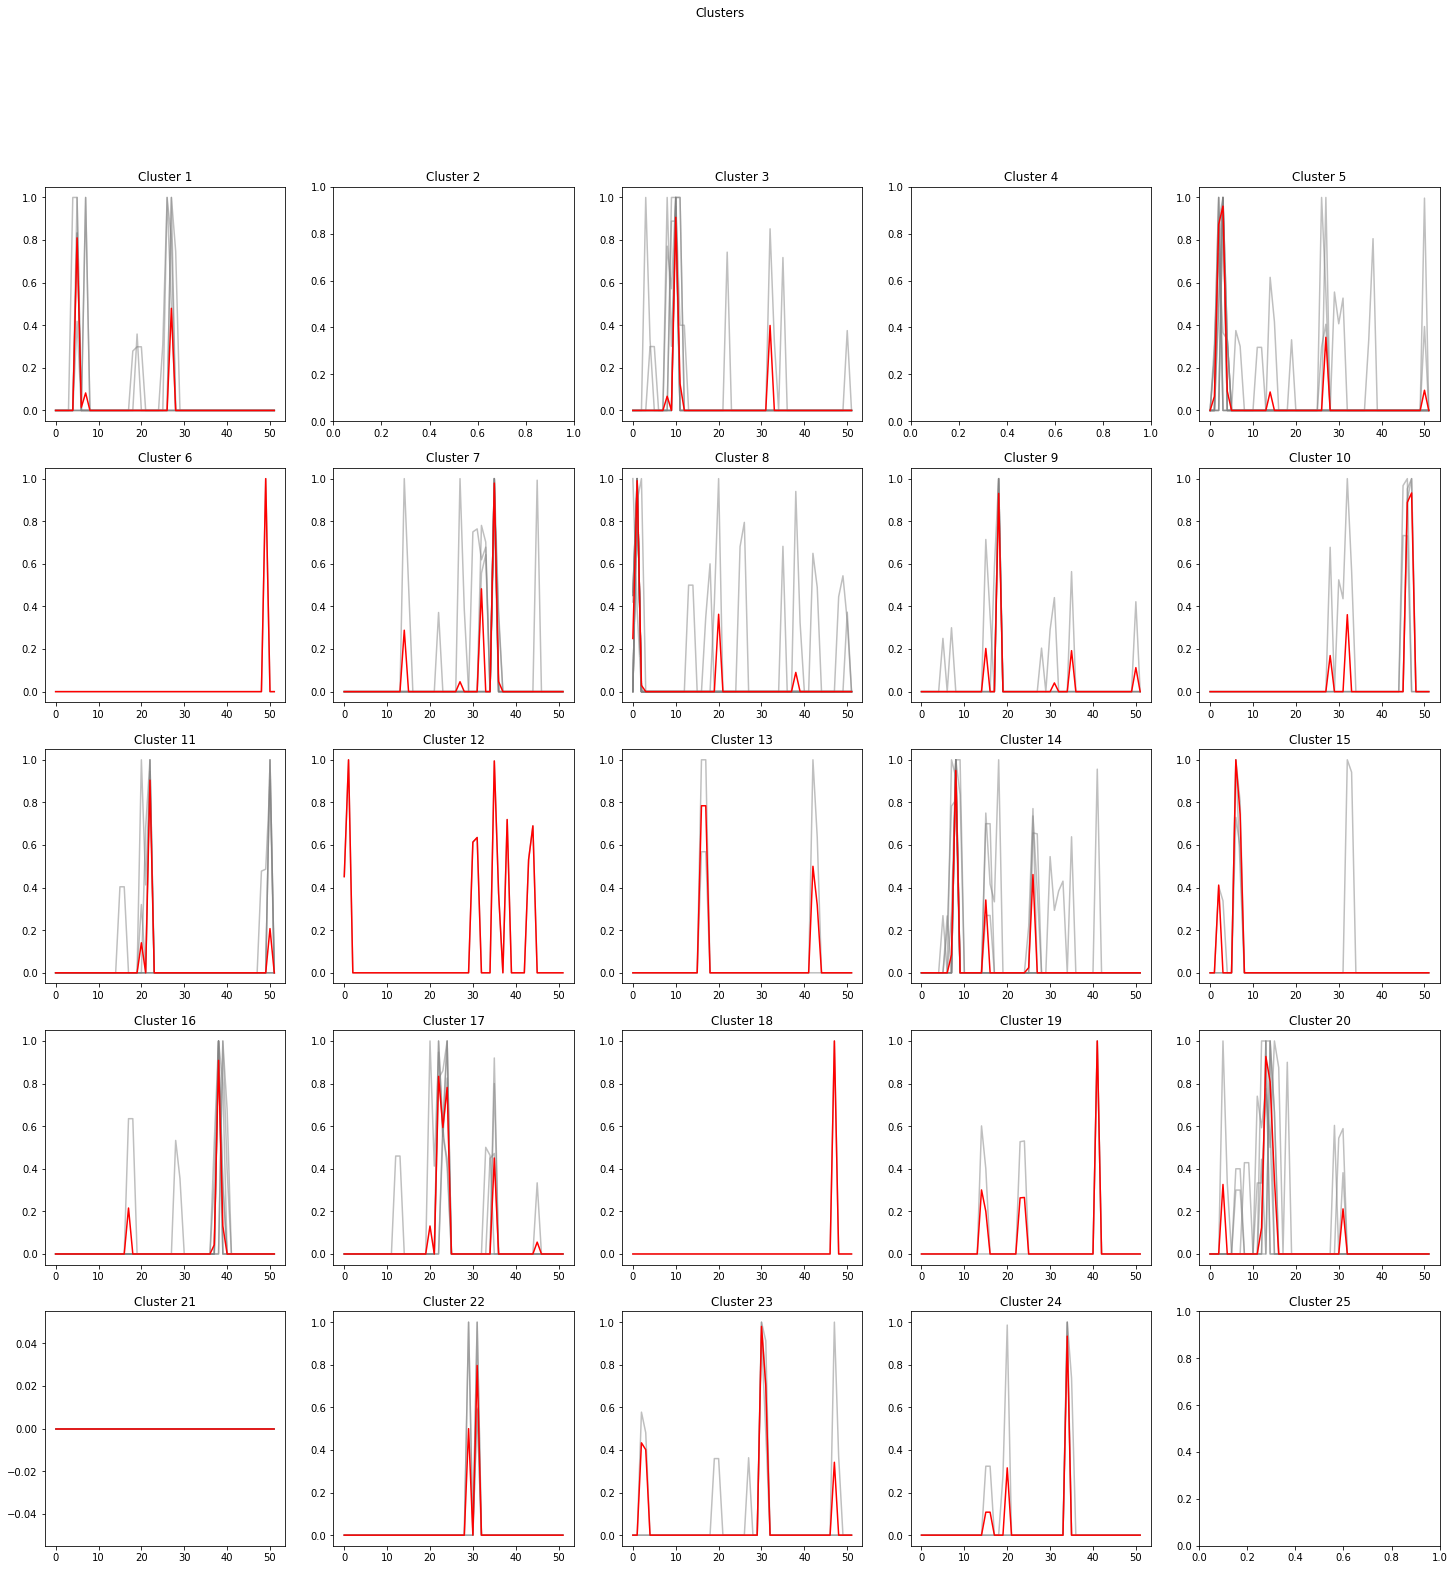

In [8]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()
win_map = som.win_map(resi_df_ls)

plot_som_series_dba_center(som_x, som_y, win_map)

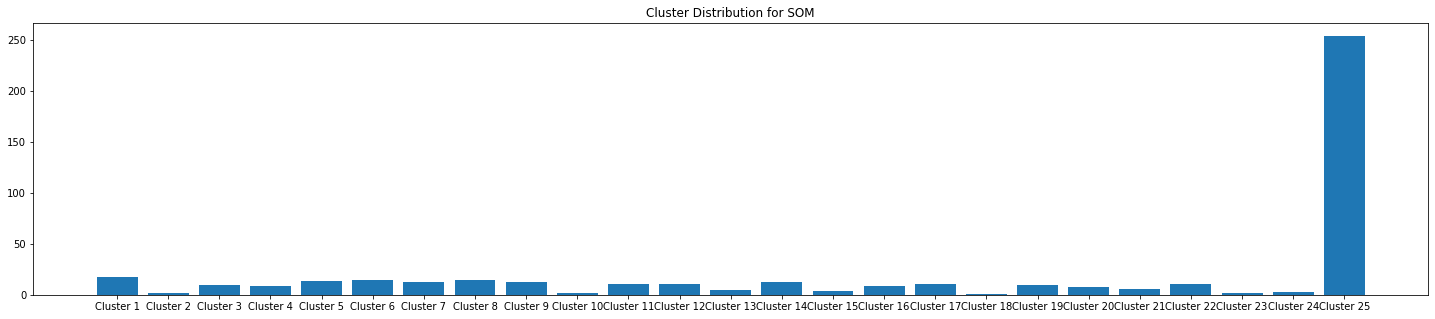

In [8]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [10]:
cluster_map = []
for idx in range(len(resi_df_ls)):
    winner_node = som.winner(resi_df_ls[idx])
    cluster_map.append((resi_ls[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

resi_cluster_df = pd.DataFrame(cluster_map,columns=["Residues","Cluster"]).sort_values(by="Cluster").set_index("Residues")
resi_cluster_df.to_csv('../result/resi_cluster.csv')

In [11]:
cluster_count = math.ceil(math.sqrt(len(resi_df_ls))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(resi_df_ls)

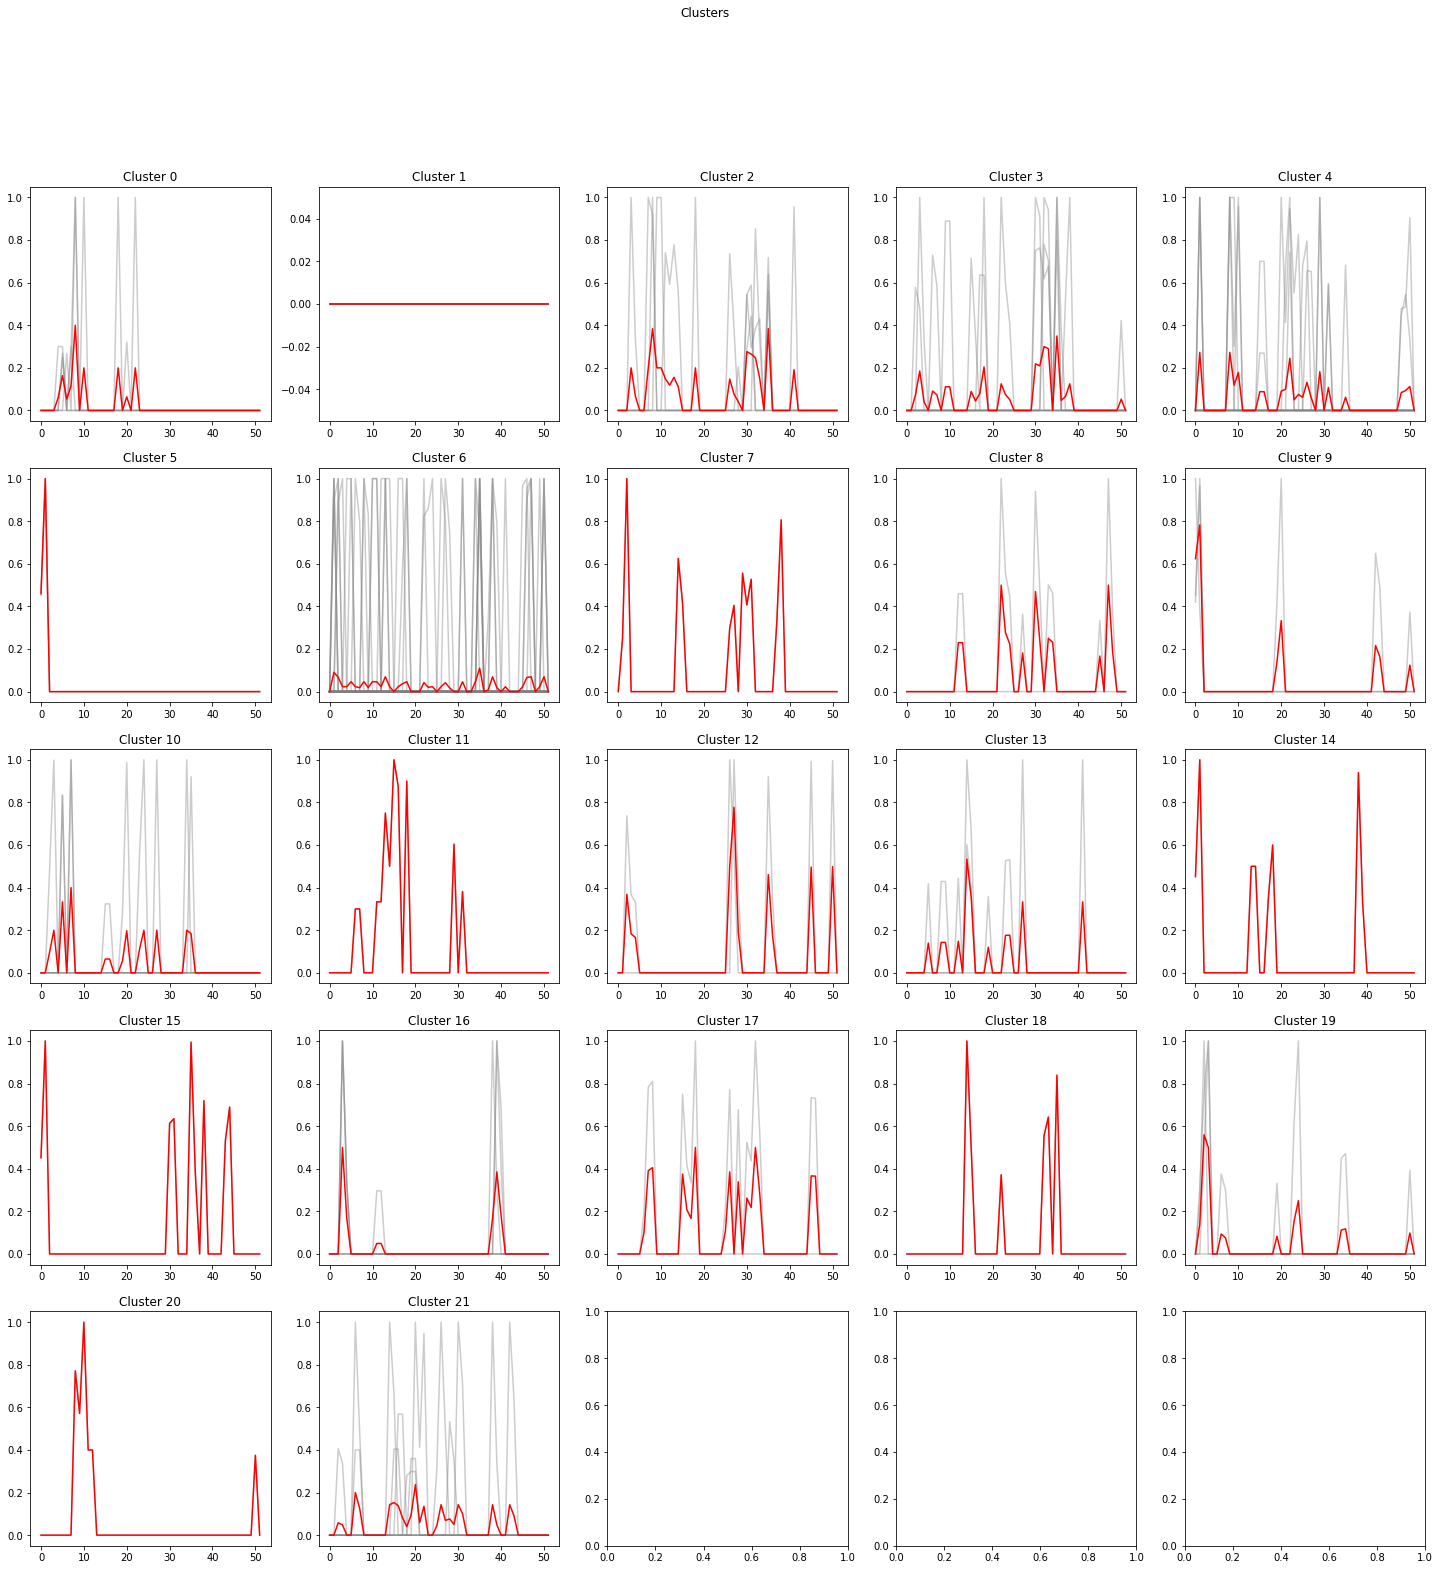

In [12]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(resi_df_ls[i],c="gray",alpha=0.4)
                cluster.append(resi_df_ls[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

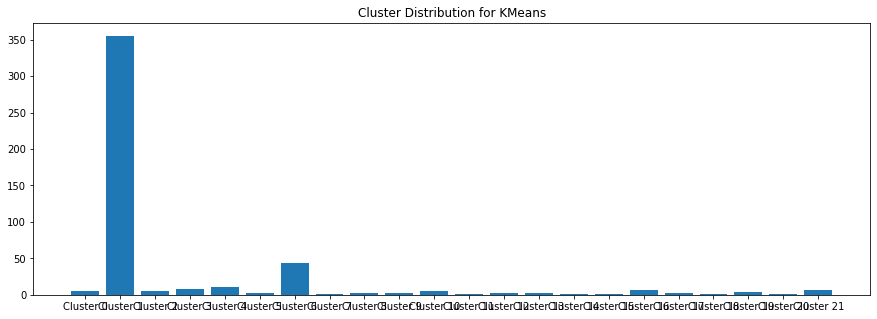

In [13]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [22]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
resi_cluster_k = pd.DataFrame(zip(resi_ls,fancy_names_for_labels),columns=["Residues","Cluster"]).sort_values(by="Cluster").set_index("Residues")
resi_cluster_k.to_csv('../result/resi_k_cluster.csv')